In [1]:
from captcha.image import ImageCaptcha
import random
from PIL import Image
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import tensorflow as tf
import os
import numpy as np

# Setup

In [2]:
number = [str(x) for x in range(10)]
alphabet = [chr(x) for x in range(97, 97+26)]
ALPHABET = [chr(x) for x in range(65, 65+26)]
CHARS_SET = number + alphabet + ALPHABET
CHARS_SET_LEN = len(CHARS_SET)

HEIGHT = 60
WIDTH = 160
CHARS_NUM=4

Captcha = ImageCaptcha(width=WIDTH,height=HEIGHT)

# Create Captcha

In [3]:
def Write_captcha(n,path="./train"):
    label = ''.join(random.sample(CHARS_SET,CHARS_NUM))
    Captcha.write(label,f'{path}/{label}_{n}.png')

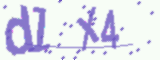

In [4]:
example = Captcha.generate("dlX4")

Image.open(example)

In [5]:
pool = ThreadPoolExecutor()
for i in range(1000): 
    pool.submit(Write_captcha,i,"./train")
pool.shutdown(wait=True)

In [6]:
pool = ThreadPoolExecutor()
for i in range(1000):
    pool.submit(Write_captcha,i,"./test")
pool.shutdown(wait=True)

# To TFRecord

## Setup

In [7]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [8]:
def serialize(string,image):
    feature = {
      'Label': _bytes_feature(string.encode()),
      'Image_raw': _bytes_feature(image.tobytes()),
    }

    proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return proto.SerializeToString()

## Method 1

In [9]:
def totfrecord1(name="train.tfrecord",path="train"):
    with tf.io.TFRecordWriter(name) as writer:
        for file in os.listdir(f"{path}/"):
            label = file.split("_")[0]
            image_raw = Image.open(f"{path}/{file}")
            proto = serialize(label,np.asarray(image_raw,dtype=np.uint8))
            writer.write(proto)

In [10]:
totfrecord1("train.tfrecord","train")

In [11]:
totfrecord1("test.tfrecord","test")

## Method 2

In [12]:
def Create_captcha():
    label = ''.join(random.sample(CHARS_SET,CHARS_NUM))
    cap = Captcha.generate(label)
    img = Image.open(cap)
    return label,np.asarray(img,dtype=np.uint8)

In [13]:
def totfrecord2(name="train.tfrecord",count=1000):
    with tf.io.TFRecordWriter(name) as writer:
        for _ in range(count):
            label,image_raw = Create_captcha()
            proto = serialize(label,image_raw)
            writer.write(proto)

In [14]:
totfrecord2("train.tfrecord",1000)

In [15]:
totfrecord2("test.tfrecord",1000)

# Check TFRecord

In [16]:
image_feature_description={
    "Label" : tf.io.FixedLenFeature([],tf.string),
    "Image_raw" : tf.io.FixedLenFeature([],tf.string),
}

def parse_tf_example(example):
    parse_example = tf.io.parse_single_example(example,image_feature_description)
    image = tf.io.decode_raw(parse_example["Image_raw"],tf.uint8) 
    image = tf.reshape(image,(HEIGHT,WIDTH,3))
    label = parse_example["Label"]
    
    return label,image

In [17]:
raw_data = tf.data.TFRecordDataset("train.tfrecord")
dataset = raw_data.map(parse_tf_example)
data_ds = dataset.shuffle(buffer_size=1000).batch(10)

In [18]:
for batch,(x,y) in enumerate(data_ds):
    labels = x.numpy()
    img = y

In [19]:
labels

array([b'2Jhn', b'DY5N', b'XTPL', b'zOos', b'XWrK', b'F1rW', b'D1NE',
       b'MvLB', b'oyBj', b'kLPH'], dtype=object)

In [20]:
img.shape

TensorShape([10, 60, 160, 3])

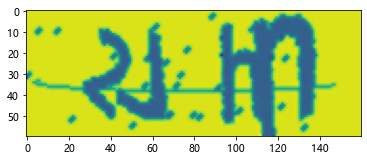

In [21]:
plt.imshow(img[0,...,0])